##Looking at volatility strategies in R

In this document, we'll look at a particular family of volatility strategy that we'll call **VIA** (for Volatility Index Arbitrage), but which we hope to generalize.

The core insight behind the strategy is simple.  If we combine an instrument, **I**, with a strongly anti-correlated instrument, **V**, we will yield a new instrument **IV** which has similar characteristics to the original but with broadly lower volatility.  This means that we've improved the Sharpe ratio of the new instrument.  By levering this synthetic instrument, we can beat the original instrument with respect to absolute returns, volatility and drawdowns under most market environments.

The benchmark for this strategy is the S&P 500 Index and it is implemented on top of S&P 500 Index Futures (ES) and VIX Futures (VX).  In general, we will trade the front month of the ES contract (ES1) and the second month of the VX contract (VX2).  The two are blended via a hedge ratio (HR) which we will examine and define below.  

We can say that at any time t, our position $P_{t}$ will be:

$$ P_{t} = L * (ES1 + HR_{t} * VX2) $$

where:

$ L $ is the strategy's overall leverage 

$ HR_{t} $ is the hedge ratio at time t 

We'll compare this return stream against the returns of the SP which will be proxied by ES1.

In general, we expect the returns of the strategy to be lower volatility than those of the benchmark, but should show a big improvement in sharpe ratio.  By constructing a portfolio which volatility-matches the index, we should be able to beat the index in terms of sharpe ratio and maximum drawdown while still matching or beating the index's returns.



###Approach:

- We'll import requisite libraries
- define instruments we care about on [Quandl](http://quandl.com) (data source website) 
- define some functions for pulling the data and building base-line universe
- define and look at some basic constructions on top of the raw data
- look at some simple portfolio rulesets ('strategies') based on those constructions


*Note that to run this, you'll need to use [IRKernel](https://irkernel.github.io/) or something similar...

### import requisite libraries

In [2]:
library(Quandl)
library(PerformanceAnalytics)
library(futile.logger)
library(data.table)
library(ggplot2)
library(quantmod)
library(TTR)

qkey <- Sys.getenv( 'QUANDL_AUTH' )

Quandl.api_key(qkey)


###define instruments we care about

In [2]:
# quandl codes

SP_FUTS_QCODE  <- 'CHRIS/CME_ES'   # s&p futures
VIX_FUTS_QCODE <- 'CHRIS/CBOE_VX'  # volatility futures

GC_FUTS_QCODE  <- 'CHRIS/CME_GC'
TU_FUTS_QCODE  <- 'CHRIS/CME_TU'
TY_FUTS_QCODE  <- 'CHRIS/CME_TY'


VIX_QCODE      <- 'CBOE/VIX'       # vix index 
VVIX_QCODE     <- 'CBOE/VVIX'      # vvix index
VXV_QCODE      <- 'CBOE/VXV'       # vxv index

SPY_QCODE      <- 'GOOG/NYSE_SPY'  # SPY ETF


### define functions for pulling data...

In [3]:
# get continuous contracts
get.ccs <- function (indices=1:2, quandl.code=SP_FUTS_QCODE, type='xts' ) {
    nm <- paste(quandl.code,indices,sep='')
    ccs <- lapply(nm,function(n) {
             flog.info(n)  
             Quandl(n,type=type)
    })
    names(ccs) <- nm
    ccs
}

### ... and creating a baseline universe

In [4]:
build.us.univ <- function(from.dt='2008-01-01') {

  # get vol futures
  vxs <- get.ccs(indices=1:6, quandl.code=VIX_FUTS_QCODE, type='xts')
  
  # we want them as returns
  vxr <- do.call('merge',lapply(vxs,function(x) { Return.calculate(x$Close) }))
  names(vxr) <- paste('VX',rep(1:6),sep='')
  
  vxc <- do.call('merge',lapply(vxs,function(x) { x$Close }))
  names(vxc) <- paste('VX',rep(1:6),'.close', sep='')
  
  # we need the VIX & VVIX, too
  VIX <- Quandl(VIX_QCODE, type='xts')
  VVIX <- Quandl(VVIX_QCODE, type='xts')
  VXV <- Quandl(VXV_QCODE, type='xts')
  SPY <- Quandl(SPY_QCODE,type='xts')
  #VXX <- Quandl(VXX_QCODE,type='xts')
  
  # let's get continuous s&p too
  spfs <- get.ccs(indices=1:2,quandl.code=SP_FUTS_QCODE)
  spr <- do.call('merge',lapply(spfs,function(x) { Return.calculate(x$Settle) }))
  names(spr) <- paste('ES',rep(1:2),sep='')
  
  spc <- do.call('merge',lapply(spfs,function(x) { x$Settle }))
  names(spc) <- paste('ES',rep(1:2),'.close',sep='')

  # now get'em all into one universe
  U <- merge(SPY[,4],VIX[,4],VVIX, VXV[,4])
  names(U) <-c('SPY','VIX','VVIX', 'VXV')
  
  # initial hedge ratio
  U$hr <- U$VIX/U$VVIX

  U <- merge( U, spc, vxc)
  
  spt1 <- lag(spr,-1)
  names(spt1) <- paste(names(spr),'tp1',sep='.')
  
  vxt1 <- lag(vxr,-1)
  names(vxt1) <- paste(names(vxr),'tp1',sep='.')
  
  U <- merge(U,spt1,vxt1)

  # define contango, IVTS, CMV & beta
  U$Contango <- (U$VX6.close-U$VIX)/U$VX6.close
  U$IVTS <- U$VIX/U$VXV # when greater > 1 we're long vol
  U$CMV <- log(U$VXV/U$VIX)
  U <- U[index(U)>from.dt]
  U
}


### let's create and look at universe, then add-in the beta adjustment

In [5]:
look.back <- 9
U <- build.us.univ()
U <- U[complete.cases(U),]
#U <- U[U.]

beta.sm <- sapply(1:nrow(U), function(j) {
    if ( j < look.back+1 ) return (NA)
    u <- U[(j-look.back):(j-1),]
    m <- do.call('lm', c(list(formula=y ~ 0 + x, 
                            data=data.frame(y = 100 * sqrt(365) * as.numeric(Return.calculate(u$SPY, method='log')), 
                                            x = 100 * sqrt(365) * as.numeric(Return.calculate(u$VIX, method='log'))))));
    coef(m)
})

U$beta <- beta.sm
U <- U[complete.cases(U),]


head(U)


INFO [2017-01-18 12:48:00] CHRIS/CBOE_VX1
INFO [2017-01-18 12:48:01] CHRIS/CBOE_VX2
INFO [2017-01-18 12:48:02] CHRIS/CBOE_VX3
INFO [2017-01-18 12:48:03] CHRIS/CBOE_VX4
INFO [2017-01-18 12:48:04] CHRIS/CBOE_VX5
INFO [2017-01-18 12:48:05] CHRIS/CBOE_VX6
INFO [2017-01-18 12:48:08] CHRIS/CME_ES1
INFO [2017-01-18 12:48:09] CHRIS/CME_ES2


              SPY   VIX  VVIX   VXV        hr ES1.close ES2.close VX1.close
2008-01-15 138.17 23.34 81.13 24.39 0.2876864   1388.00   1393.50     23.95
2008-01-16 136.98 24.38 80.51 24.36 0.3028195   1376.00   1381.50     24.18
2008-01-17 133.43 28.46 84.99 26.44 0.3348629   1339.75   1344.25     26.97
2008-01-18 132.06 27.18 77.24 25.99 0.3518902   1325.25   1330.00     27.12
2008-01-22 130.72 31.01 86.58 27.39 0.3581659   1309.25   1312.50     27.65
2008-01-23 133.86 29.02 82.68 26.25 0.3509918   1342.00   1345.00     26.35
           VX2.close VX3.close VX4.close VX5.close VX6.close      ES1.tp1
2008-01-15     25.32     25.10     25.23     24.95     24.75 -0.008645533
2008-01-16     25.00     25.00     25.00     24.99     24.60 -0.026344477
2008-01-17     26.70     26.60     26.50     26.41     26.10 -0.010822915
2008-01-18     26.70     26.58     26.20     25.88     26.20 -0.045085833
2008-01-22     26.40     26.20     25.75     25.58     25.85  0.025014321
2008-01-23     25.50    

##strategies 

We define a benchmark:
 - **ES** buy and hold front-month of ES
 
And a number of simple strategies:
 - **Const.1** buy and hold front-month of ES and maintain a constant .1 allocation of VX2
 - **HR** buy and hold front-month of ES and maintain a VIX/VVIX ratio of VX2
 - **Beta** buy and hold front-month of ES and maintain a abs(beta) ratio of VX2
 - **BH** buy and hold front-month of ES and maintain a 1/2 * (vix/vvix + abs(beta)) ratio of VX2
 
**Const.1** illustrates the fundamental strength of the core idea of blending long index and long vol.

**HR** uses the ratio of vix/vvix as the hedge ratio.  This is essentially volatility adjusting the two positions.

**Beta** is beta adjusting the hedge.

**BH** takes the average of the **HR** and **Beta** approaches.

Since we expect the strategies to have lower volatility than the benchmark, we intentionally increase their volatility by 1.5 in the below cases.

,ES,Const.1,HR,Beta,BetaHR
Annualized Return,0.0481,0.0935,0.0881,0.1160,0.1037
Annualized Std Dev,0.2152,0.2693,0.2119,0.2340,0.2161
Annualized Sharpe (Rf=0%),0.2235,0.3474,0.4159,0.4956,0.4798


,ES,Const.1,HR,Beta,BetaHR
Worst Drawdown,0.5094902,0.6206958,0.4592781,0.453503,0.4541417


,ES,Const.1,HR,Beta,BetaHR
Kelly Ratio,0.7571436,0.8654393,1.191641,1.250814,1.306042


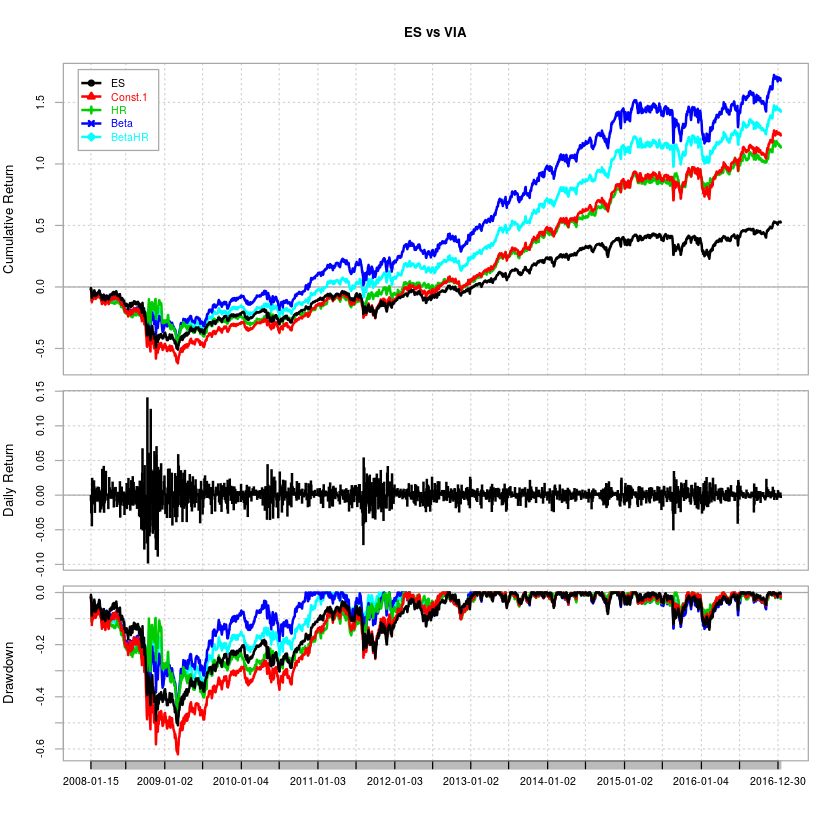

In [6]:
# the front-month
ES <- U$ES1.tp1
names(ES) <- 'ES'

# the front-month and .1 of 2nd month of vol
F1 <- U$ES1.tp1 + .1 * U$VX2.tp1
names(F1) <- 'Const.1' 
  
# the front-month and vix/VVIX of 2nd month of vol
H1 <- U$ES1.tp1 + U$hr * U$VX2.tp1
names(H1) <- 'HR'

B1 <- U$ES1.tp1 + abs(U$beta) * U$VX2.tp1 
names(B1) <- 'Beta'

BH <- U$ES1.tp1 + .5*(U$hr +abs(U$beta)) * U$VX2.tp1 
names(BH) <- 'BetaHR'

#Blend <- U$ES1.tp1 + (1/3)*(U$hr +abs(U$beta) + .1) * U$VX2.tp1 
#names(Blend) <- 'Blend'

StratLev = 1.5
Strats <- StratLev * merge(F1,H1,B1, BH)
All <- merge(ES,Strats)

charts.PerformanceSummary(All, main="ES vs VIA")
table.AnnualizedReturns(All)
maxDrawdown(All)
KellyRatio(All)

##Results 

The results are generally good over this period for all of the strategies (and the benchmark).  The strategies all yield better sharpe ratios, higher returns and, excepting the **Const.1** strategy, lower volatility and drawdowns than the benchmark.  

This illustrates the strength of the core concept: by adding a strongly anti-correlated instrument to the benchmark, we can lever and improve the returns of the benchmark.  

Below we look at the last 5 years of returns and then look at each of the strategies with the benchmark removed so we can compare them on a more apples-to-apples basis.

,ES,Const.1,HR,Beta,BetaHR
Annualized Return,0.0924,0.1716,0.1642,0.1579,0.1624
Annualized Std Dev,0.1532,0.1683,0.1378,0.1597,0.1409
Annualized Sharpe (Rf=0%),0.6028,1.0194,1.1915,0.9883,1.1526


,ES,Const.1,HR,Beta,BetaHR
Worst Drawdown,0.2238133,0.2167883,0.1266628,0.1750097,0.1489636


,ES,Const.1,HR,Beta,BetaHR
Kelly Ratio,2.13236,3.046106,4.253241,3.123008,4.040337


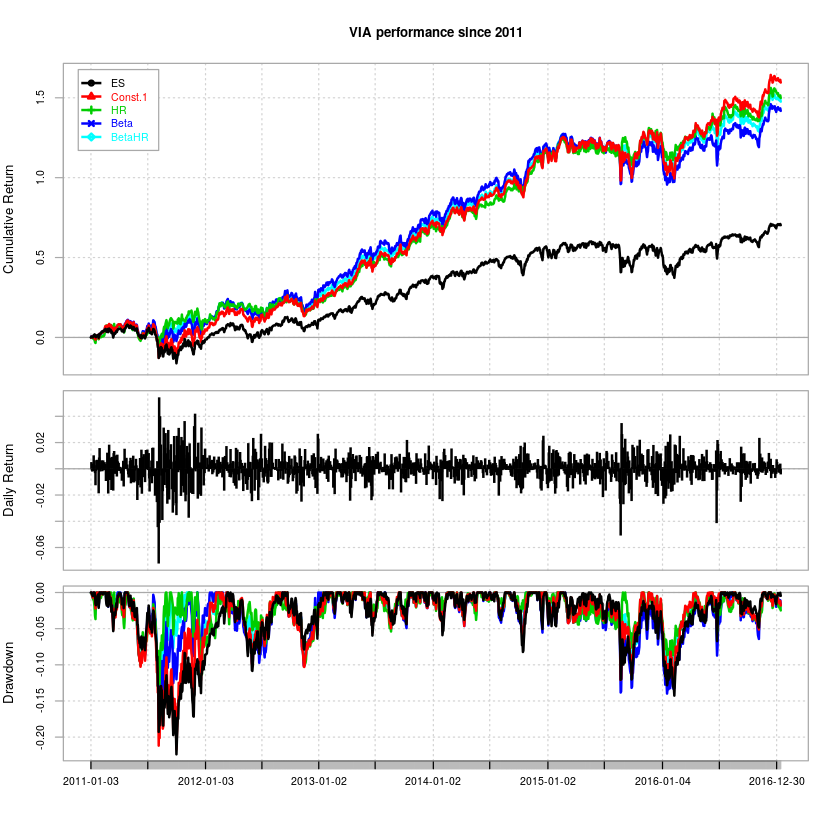

In [7]:
S =All['2011/']
charts.PerformanceSummary(S, main= 'VIA performance since 2011')
table.AnnualizedReturns(S)
maxDrawdown(S)
KellyRatio(S)

In [8]:
head(All)

                     ES     Const.1           HR         Beta       BetaHR
2008-01-15 -0.008645533 -0.01486403 -0.018422071 -0.017950255 -0.018186163
2008-01-16 -0.026344477 -0.02931672 -0.008629124 -0.008377672 -0.008503398
2008-01-17 -0.010822915 -0.01623437 -0.016234372 -0.016234372 -0.016234372
2008-01-18 -0.045085833 -0.06931414 -0.073559483 -0.070972216 -0.072265850
2008-01-22  0.025014321  0.03240785  0.019206182  0.029072912  0.024139547
2008-01-23  0.007637854  0.01057443  0.008359795  0.010298130  0.009328962

,Const.1,HR,Beta,BetaHR
Annualized Return,0.0533,0.0197,0.0629,0.0427
Annualized Std Dev,0.0834,0.1861,0.1080,0.1415
Annualized Sharpe (Rf=0%),0.6392,0.1059,0.5827,0.3018


,Const.1,HR,Beta,BetaHR
Worst Drawdown,0.1731467,0.4682116,0.17683,0.3195968


,Const.1,HR,Beta,BetaHR
Kelly Ratio,3.98148,0.5321811,2.866897,1.294807


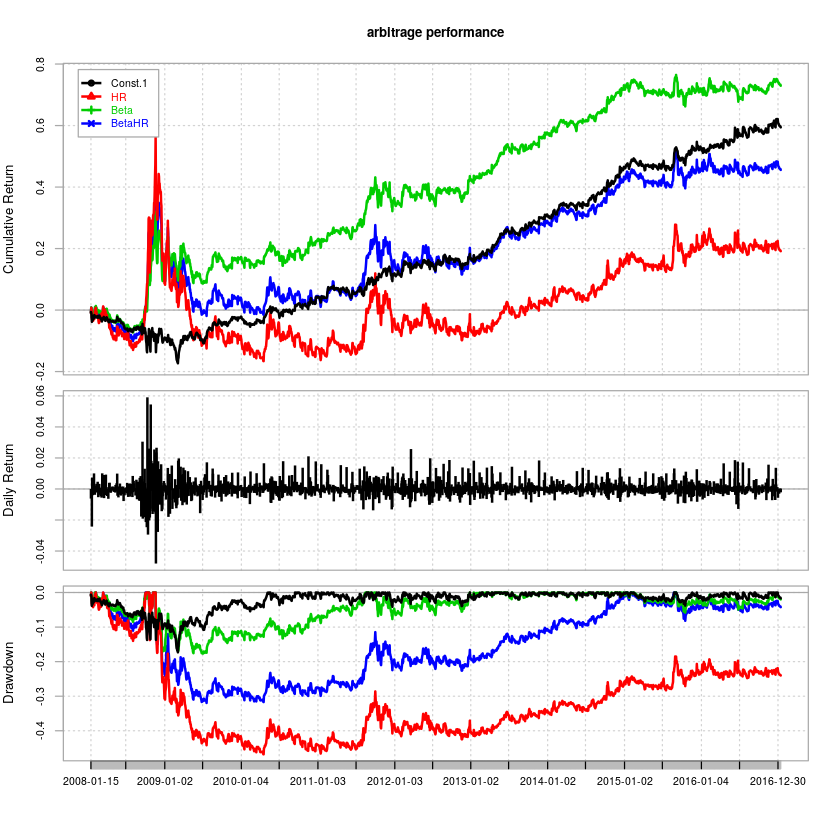

In [9]:
#table.CalendarReturns(All$ES)
#head(All)
S=All
D = merge( S$Const.1 - S$ES, S$HR - S$ES, S$Beta - S$ES, S$BetaHR - S$ES)
charts.PerformanceSummary(D, main='arbitrage performance')
table.AnnualizedReturns(D)
maxDrawdown(D)
KellyRatio(D)

In [34]:
#plot(abs(U$beta))
#mean(abs(U$beta))
#mean(U$beta)
#plot(U$hr)
S =All['2011/']
head(S)
apply(S,2,mean) * 22

                     ES       Const.1            HR          Beta        BetaHR
2011-01-03  0.000000000 -0.0003521127 -0.0007312151 -6.979857e-05 -0.0004005068
2011-01-04  0.005137325  0.0052353987  0.0026691748  7.019131e-03  0.0048441531
2011-01-05 -0.001179477 -0.0021280673 -0.0024903084 -1.834021e-03 -0.0021621646
2011-01-06 -0.002164928 -0.0025279678 -0.0017677249 -3.021991e-03 -0.0023948581
2011-01-07 -0.001577909 -0.0023668639 -0.0023668639 -2.366864e-03 -0.0023668639
2011-01-10  0.003951008  0.0016305685 -0.0033020050  9.380499e-04 -0.0011819775

ES     Const.1          HR        Beta      BetaHR 
0.008741876 0.015064700 0.014101851 0.013914929 0.014008390

## Conclusions

It looks like all variants of the strategy beat the benchmark.  The constant variety looks pretty good in most situations, with the exception being the extreme moves of 2008 and 2011.  These could be dealt with through a dynamic hedge ratio which more aggressively times the market.  This would naturally increase the danger of over fitting.  

Another danger for this strategy is when a market enters long-term doldrums where it just doesn't go anywhere.  In this case, you face an expected return of blah on the index and still find yourself paying for the vol dampener.  This may still be ok if we're improving the return stream, but we need to better understand the implications of lower & higher volatility and correlation regimes.

